# Final Project - Constrained, Multi-Objective, & Non-Linear Least Squares
### Modeling & Optimization
### Ethan Witkowski

## Part I

## Part II

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### 13.3

a)

In [14]:
#Define data values - number of transistors, year
Years = np.array([1971, 1972, 1974, 1978, 1982, 1985, 1989, 1993, 1997, 1999, 2000, 2002, 2003])
Transistors = np.array([2250, 2500, 5000, 29000, 120000, 275000, 1180000, 3100000, 7500000, 24000000, \
                        42000000, 220000000, 410000000])

#Take log of number of transistors
Transistors = np.log(Transistors)

Least Squares Solution:
<br>

$\hat{\theta} = (A^{T}A)^{-1}A^{T}y^{d}$

Root Mean Square Error:
<br>

$RMSE = \sqrt{\cfrac{\|y^{d}-A\theta\|^{2}}{N}}$

In [38]:
#Define A matrix

#Pre-allocate A
A = np.empty([len(Years), 2])

#Place in time series data
for i,year in enumerate(Years):

    A[i] = np.array([1, year])

In [49]:
#Define observed y

#Pre-allocate obeserved y
y_d = np.empty([len(Transistors), 1])

#Place in actual transistor data
for i,transistor in enumerate(Transistors):

    y_d[i] = np.array([transistor])

In [39]:
#Least Squares Solution

LS_step_1 = np.linalg.inv(np.matmul(np.transpose(A), A))

LS_step_2 = np.matmul(LS_step_1, np.transpose(A))

LS_step_3 = np.matmul(LS_step_2, y_d)

theta_hat = LS_step_3

In [23]:
#Prediction values 

Years = np.array([1971, 1972, 1974, 1978, 1982, 1985, 1989, 1993, 1997, 1999, 2000, 2002, 2003])
LS_transistor = np.empty([len(Years)])

for i,year in enumerate(Years):

    LS_transistor[i] = (theta_hat[0][0])+((theta_hat[1][0])*(year))

In [26]:
#Root Mean Square Error

#Number of observations
N = len(Transistors)

#RSME calculation
rmse = np.sqrt(np.linalg.norm(LS_transistor - Transistors) / N)

RMS minimizing $\theta_{1} = -691.44$
<br>

RMS minimizing $\theta_{2} = 0.355$
<br> 

RMS error $= .360$

<function matplotlib.pyplot.show(*args, **kw)>

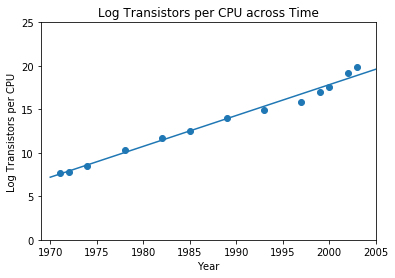

In [48]:
#Plotting data and prediction

#Continuous time, pre-allocation
continuous_year = np.arange(1970,2020)
LS_cont_transistor = np.empty([len(continuous_year)])

#Prediction
for j,cont_year in enumerate(continuous_year):

    LS_cont_transistor[j] = (theta_hat[0][0])+((theta_hat[1][0])*(cont_year))
    
#Plotting
plt.scatter(Years, Transistors)
plt.xlabel('Year')
plt.ylabel('Log Transistors per CPU')
plt.title('Log Transistors per CPU across Time')
plt.xlim([1969,2005])
plt.ylim([0,25])

plt.plot(continuous_year, LS_cont_transistor)
plt.show

b)

In [50]:
#Prediction for 2015

#Declare year, pre-allocation
year_2015 = np.array([2015])
LS_2015_transistor = np.empty([len(year_2015)])

#Prediction 2015
for k,year in enumerate(year_2015):

    LS_2015_transistor[k] = (theta_hat[0][0])+((theta_hat[1][0])*(year))

#Reverse logarithmic transformation
LS_2015_transistor = np.exp(LS_2015_transistor)

The predicted number of transistors per CPU in 2015 is $1.14 \times 10^{10}$. The predicted value is $7.4 \times 10^{9}$ transistors per CPU greater than the actual number of transistors per CPU in 2015, $4 \times 10^{9}$.

c)

In [52]:
#Reverse logarithmic transformation of theta_2
actual_theta_2 = np.exp(theta_hat[1][0])
print(actual_theta_2)

1.4256672716945757


The least squares model predicts the number of transistors per CPU will be multiplied by 1.43 each year. This is lower than Moore's Law, which predicts the doubling of transistors per CPU each year.